Vu Ngoc Linh 

# NLP with DL - Week 2

Build a Deep Neuron Network to classify news into 10 topics.

## 1 - Packages

import dnn_app_utils_v2 provides the functions implemented in the W1 homework

In [33]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Dataset

In [34]:
df = pd.read_csv('datasets/News/all_news.csv')
df.head()

text    label
0   Ông đồ cuối cùng trên đảo\n“Vua Tần cỡi cọp c...  Van hoa
1   Kịch hài định kỳ Cậu Tèo về quê - vở kịch hài...  Van hoa
2  Hồ Ngọc Hà: 'Thời trang cổ điển là sự vĩnh cửu...  Van hoa
3   Ta tự hào đi lên - Ôi VN Chương trình ca nhạc...  Van hoa
4  3 tỷ đồng cho live show Mỹ Tâm\nKinh phí dự tí...  Van hoa

In [3]:
df['label'].value_counts()

The thao            5298
Chinh tri Xa hoi    5219
Phap luat           3868
Suc khoe            3384
Doi song            3159
Van hoa             3080
The gioi            2898
Kinh doanh          2552
Vi tinh             2481
Khoa hoc            1820
Name: label, dtype: int64

In [175]:
df['label'].value_counts().plot.barh(figsize=(5, 5))

In [176]:
# news example
df[df['label'] == 'Phap luat'].iloc[0, 0]

'Xét xử lại vụ môi giới mại dâm liên quan một viện phó VKS\nSau khi nghị án 15 ngày, hôm qua, TAND tỉnh Bình Dương vẫn chưa thể tuyên án với 12 bị cáo trong vụ môi giới mại dâm, mua dâm người chưa thành niên do Nguyễn Thị Mửng cầm đầu. Nhiều lời khai tại toà cho thấy, Phó viện trưởng VKS Bình Dương Nguyễn Thành Phương có liên quan vụ việc.\nViện phó VKS xét xử phúc thẩm VKSND Tối cao tại TP HCM Lê Thành Dương nói: "Từ trước tới nay, tôi chưa từng thấy vụ án nào mà thời gian nghị án kéo dài đến 15 ngày. Ngay cả các vụ lớn như Tân Trường Sanh, Minh Phụng - Epco hay Năm Cam, thời gian cũng chỉ 5-7 ngày". \nChánh án TAND tỉnh Bình Dương Nguyễn Thanh Tùng cho biết, sau khi nghị án HĐXX thấy còn nhiều tình tiết chưa được làm rõ, nên vụ án sẽ được đưa ra xét xử lại vào ngày 23/4.\nTheo ông Tùng, thời gian nghị án lâu như vừa qua là do phải đánh giá chứng cứ, xác định hành vi của các bị cáo, chứ không phải vì vụ án có liên quan tới ông Phương.\nTheo kết quả xác minh của công an, bị cáo Nguyễn 

In [35]:
# split the dataset into training and test datasets 
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['text'], df['label'])

# label encode the target variable, encode labels to 0, 1, 2
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

topics = df['label'].unique()
topics_df = pd.DataFrame({"topic": topics}, index=encoder.transform(topics))
topics_df

topic
8           Van hoa
6          The gioi
2          Khoa hoc
5          Suc khoe
0  Chinh tri Xa hoi
9           Vi tinh
3        Kinh doanh
7          The thao
4         Phap luat
1          Doi song

*** We need to transform Y to array of one hot encoded vector, example: ***
```
[3, 0, 9] => [[0,0,1,0,0,0,0,0,0,0], [1,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,1]]
```

In [36]:
train_y = one_hot_array(train_y)
test_y = one_hot_array(test_y)

#### TF-IDF Vectors as features

In [37]:
stopwords = load_stopwords("datasets/vietnamese-stopwords.txt")

there are 1942 stopwords


In [284]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words = stopwords,
                             max_features=5000, ngram_range=(1,2))
tfidf_vect.fit(df['text'])

# output of tfidf transform is sparse matrix, which is not allow us to apply normal matrix calculation
# => we need to convert to dense matrix
xtrain_tfidf =  tfidf_vect.transform(train_x).T.toarray()
xtest_tfidf =  tfidf_vect.transform(test_x).T.toarray()

# Getting transformed training and testing dataset
print('Number of training documents: %s' %str(xtrain_tfidf.shape[1]))
print('Number of testing documents: %s' %str(xtest_tfidf.shape[1]))
print('Number of features of each document: %s' %str(xtrain_tfidf.shape[0]))
print('xtrain_tfidf shape: %s' %str(xtrain_tfidf.shape))
print('train_y shape: %s' %str(train_y.shape))
print('xtest_tfidf shape: %s' %str(xtest_tfidf.shape))
print('test_y shape: %s' %str(test_y.shape))

Number of training documents: 25319
Number of testing documents: 8440
Number of features of each document: 5000
xtrain_tfidf shape: (5000, 25319)
train_y shape: (10, 25319)
xtest_tfidf shape: (5000, 8440)
test_y shape: (10, 8440)


## 3 - Architecture of your model

Let's build 2 different models:
- A 2-layer neural network: ***INPUT -> LINEAR -> RELU -> LINEAR -> SOFTMAX -> OUTPUT***
- An L-layer deep neural network: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SOFTMAX***

, then compare the performance of these models, and also try out different values for $L$. 

### General methodology

    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels


## 4 - Two-layer neural network

Structure: ***LINEAR -> RELU -> LINEAR -> SOFTMAX***. The functions used and their inputs are:

```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(A_prev, Y, dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [285]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 5000
n_h = 300
n_y = 10
layers_dims = (n_x, n_h, n_y)

In [286]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.1, num_iterations = 2000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X,W1,b1,activation='relu')
        A2, cache2 = linear_activation_forward(A1,W2,b2,activation='softmax')
        
        #Y = Y.reshape(A2.shape)
        
        # Compute cost
        cost = compute_cost(A2,Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation='softmax')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu') 
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters,grads,learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
#         Print the cost every 100 training example
#         if print_cost and i % 100 == 0:
        print("Cost after iteration {}: {}".format(i, cost))
        costs.append(cost)
       
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Run the cell below to train your parameters. See if your model runs. The cost should be decreasing.

In [336]:
parameters = two_layer_model(xtrain_tfidf, train_y, layers_dims = (n_x, n_h, n_y), 
                             learning_rate = 1, num_iterations = 500, print_cost=True)


Cost after iteration 0: 2.3025903885533916
Cost after iteration 1: 2.292601486565774
Cost after iteration 2: 2.28453778952938
Cost after iteration 3: 2.2780446470285742
Cost after iteration 4: 2.2728252447427897
Cost after iteration 5: 2.2686325962113374
Cost after iteration 6: 2.26526303202803
Cost after iteration 7: 2.2625495273425993
Cost after iteration 8: 2.260356391200071
Cost after iteration 9: 2.2585741954797416
Cost after iteration 10: 2.2571149693402868
Cost after iteration 11: 2.2559086281238345
Cost after iteration 12: 2.254899321734743
Cost after iteration 13: 2.2540424683003364
Cost after iteration 14: 2.253302917609626
Cost after iteration 15: 2.2526526030799823
Cost after iteration 16: 2.2520691150179535
Cost after iteration 17: 2.2515348564510465
Cost after iteration 18: 2.2510353947590933
Cost after iteration 19: 2.250559140080147
Cost after iteration 20: 2.2500965549736285
Cost after iteration 21: 2.2496398909381874
Cost after iteration 22: 2.2491824234125217
Cost af

Cost after iteration 187: 0.979848164567986
Cost after iteration 188: 0.9709635070548115
Cost after iteration 189: 0.9621762900196156
Cost after iteration 190: 0.9534872665249526
Cost after iteration 191: 0.9448971006169755
Cost after iteration 192: 0.9364063062330428
Cost after iteration 193: 0.9280155106995489
Cost after iteration 194: 0.919725285352765
Cost after iteration 195: 0.9115362329165648
Cost after iteration 196: 0.9034488211032331
Cost after iteration 197: 0.8954635026284488
Cost after iteration 198: 0.8875806339810826
Cost after iteration 199: 0.8798005294173493
Cost after iteration 200: 0.8721234524720293
Cost after iteration 201: 0.8645496076910489
Cost after iteration 202: 0.8570791911532313
Cost after iteration 203: 0.8497122896715238
Cost after iteration 204: 0.8424489903945999
Cost after iteration 205: 0.8352892251193454
Cost after iteration 206: 0.8282328799454365
Cost after iteration 207: 0.8212797478066122
Cost after iteration 208: 0.8144295803313437
Cost after i

Cost after iteration 369: 0.3979264146156503
Cost after iteration 370: 0.39694594272361167
Cost after iteration 371: 0.3959720325032023
Cost after iteration 372: 0.39500462224192
Cost after iteration 373: 0.39404364714571866
Cost after iteration 374: 0.393089037429271
Cost after iteration 375: 0.392140734414847
Cost after iteration 376: 0.3911986678618738
Cost after iteration 377: 0.39026278292439853
Cost after iteration 378: 0.38933301969254475
Cost after iteration 379: 0.38840931672409346
Cost after iteration 380: 0.387491592552728
Cost after iteration 381: 0.38657981730748786
Cost after iteration 382: 0.3856739369915516
Cost after iteration 383: 0.3847738870941958
Cost after iteration 384: 0.3838796151366333
Cost after iteration 385: 0.3829910690329807
Cost after iteration 386: 0.38210820215105107
Cost after iteration 387: 0.3812309514613508
Cost after iteration 388: 0.38035926267105663
Cost after iteration 389: 0.37949308559744765
Cost after iteration 390: 0.37863236789013555
Cost 

It might have taken 10 times longer to train this.

Now, use the trained parameters to classify news from the dataset:

In [337]:
y_train_pred = predict(xtrain_tfidf, parameters)
train_accuracy = evaluate(y_train_pred, train_y)

Accuracy: 90.97120739365694 %


In [338]:
y_test_pred = predict(xtest_tfidf, parameters)
test_accuracy = evaluate(y_test_pred, test_y)

Accuracy: 88.56635071090048 %


**Note**: Running the model on fewer iterations may gives better accuracy on the test set. This is called "early stopping", a way to prevent overfitting. 

It seems that 2-layer neural network has better performance than the logistic regression implementation. Let's see if we can do even better with an $L$-layer model.

## 5 - L-layer Neural Network

**Question**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [268]:
### CONSTANTS ###
layers_dims_L = [5000, 300, 100, 40, 10] #  4-layer model

In [340]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.1, num_iterations = 2000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X,parameters)
        
        # Compute cost.
        cost = compute_cost(AL,Y)
    
        # Backward propagation.
        grads = L_model_backward(AL,Y,caches)
 
        # Update parameters.
        parameters = update_parameters(parameters,grads,learning_rate)

        # Print the cost every 100 training example
#         if print_cost and i % 100 == 0:
        print ("Cost after iteration %i: %f" %(i, cost))
        costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 4-layer neural network. 

Run the cell below to train your model. The cost should decrease on every iteration.

Cost after iteration 0: 2.302585
Cost after iteration 1: 2.292846
Cost after iteration 2: 2.284986
Cost after iteration 3: 2.278674
Cost after iteration 4: 2.273621
Cost after iteration 5: 2.269586
Cost after iteration 6: 2.266369
Cost after iteration 7: 2.263805
Cost after iteration 8: 2.261763
Cost after iteration 9: 2.260134
Cost after iteration 10: 2.258834
Cost after iteration 11: 2.257794
Cost after iteration 12: 2.256960
Cost after iteration 13: 2.256289
Cost after iteration 14: 2.255748
Cost after iteration 15: 2.255310
Cost after iteration 16: 2.254953
Cost after iteration 17: 2.254663
Cost after iteration 18: 2.254424
Cost after iteration 19: 2.254228
Cost after iteration 20: 2.254066
Cost after iteration 21: 2.253931
Cost after iteration 22: 2.253819
Cost after iteration 23: 2.253725
Cost after iteration 24: 2.253646
Cost after iteration 25: 2.253579
Cost after iteration 26: 2.253522
Cost after iteration 27: 2.253474
Cost after iteration 28: 2.253433
Cost after iteration 29:

Cost after iteration 238: 2.253163
Cost after iteration 239: 2.253163
Cost after iteration 240: 2.253163
Cost after iteration 241: 2.253163
Cost after iteration 242: 2.253163
Cost after iteration 243: 2.253163
Cost after iteration 244: 2.253163
Cost after iteration 245: 2.253163
Cost after iteration 246: 2.253163
Cost after iteration 247: 2.253163
Cost after iteration 248: 2.253163
Cost after iteration 249: 2.253163
Cost after iteration 250: 2.253163
Cost after iteration 251: 2.253163
Cost after iteration 252: 2.253163
Cost after iteration 253: 2.253163
Cost after iteration 254: 2.253163
Cost after iteration 255: 2.253163
Cost after iteration 256: 2.253163
Cost after iteration 257: 2.253163
Cost after iteration 258: 2.253163
Cost after iteration 259: 2.253163
Cost after iteration 260: 2.253163
Cost after iteration 261: 2.253163
Cost after iteration 262: 2.253163
Cost after iteration 263: 2.253163
Cost after iteration 264: 2.253163
Cost after iteration 265: 2.253163
Cost after iteration

Cost after iteration 473: 2.253162
Cost after iteration 474: 2.253162
Cost after iteration 475: 2.253162
Cost after iteration 476: 2.253162
Cost after iteration 477: 2.253162
Cost after iteration 478: 2.253162
Cost after iteration 479: 2.253162
Cost after iteration 480: 2.253162
Cost after iteration 481: 2.253162
Cost after iteration 482: 2.253162
Cost after iteration 483: 2.253162
Cost after iteration 484: 2.253162
Cost after iteration 485: 2.253162
Cost after iteration 486: 2.253162
Cost after iteration 487: 2.253162
Cost after iteration 488: 2.253162
Cost after iteration 489: 2.253162
Cost after iteration 490: 2.253162
Cost after iteration 491: 2.253162
Cost after iteration 492: 2.253162
Cost after iteration 493: 2.253162
Cost after iteration 494: 2.253162
Cost after iteration 495: 2.253162
Cost after iteration 496: 2.253162
Cost after iteration 497: 2.253162
Cost after iteration 498: 2.253162
Cost after iteration 499: 2.253162
Cost after iteration 500: 2.253162
Cost after iteration

Cost after iteration 708: 2.253162
Cost after iteration 709: 2.253162
Cost after iteration 710: 2.253162
Cost after iteration 711: 2.253162
Cost after iteration 712: 2.253162
Cost after iteration 713: 2.253162
Cost after iteration 714: 2.253162
Cost after iteration 715: 2.253162
Cost after iteration 716: 2.253162
Cost after iteration 717: 2.253162
Cost after iteration 718: 2.253162
Cost after iteration 719: 2.253162
Cost after iteration 720: 2.253162
Cost after iteration 721: 2.253162
Cost after iteration 722: 2.253162
Cost after iteration 723: 2.253162
Cost after iteration 724: 2.253162
Cost after iteration 725: 2.253162
Cost after iteration 726: 2.253162
Cost after iteration 727: 2.253162
Cost after iteration 728: 2.253162
Cost after iteration 729: 2.253162
Cost after iteration 730: 2.253162
Cost after iteration 731: 2.253162
Cost after iteration 732: 2.253162
Cost after iteration 733: 2.253162
Cost after iteration 734: 2.253162
Cost after iteration 735: 2.253162
Cost after iteration

Cost after iteration 943: 2.253161
Cost after iteration 944: 2.253161
Cost after iteration 945: 2.253161
Cost after iteration 946: 2.253161
Cost after iteration 947: 2.253161
Cost after iteration 948: 2.253161
Cost after iteration 949: 2.253161
Cost after iteration 950: 2.253161
Cost after iteration 951: 2.253161
Cost after iteration 952: 2.253161
Cost after iteration 953: 2.253161
Cost after iteration 954: 2.253161
Cost after iteration 955: 2.253161
Cost after iteration 956: 2.253161
Cost after iteration 957: 2.253161
Cost after iteration 958: 2.253161
Cost after iteration 959: 2.253161
Cost after iteration 960: 2.253161
Cost after iteration 961: 2.253161
Cost after iteration 962: 2.253161
Cost after iteration 963: 2.253161
Cost after iteration 964: 2.253161
Cost after iteration 965: 2.253161
Cost after iteration 966: 2.253161
Cost after iteration 967: 2.253161
Cost after iteration 968: 2.253161
Cost after iteration 969: 2.253161
Cost after iteration 970: 2.253161
Cost after iteration

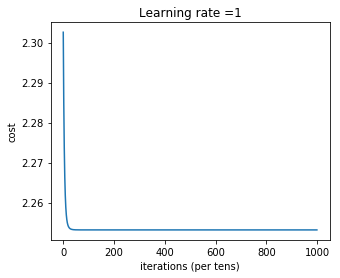

In [305]:
parameters_L = L_layer_model(xtrain_tfidf, train_y, layers_dims_L, 
                           learning_rate = 1, num_iterations = 1000, print_cost = True)

In [306]:
y_train_pred_L = predict(xtrain_tfidf, parameters_L)
train_accuracy = evaluate(y_train_pred_L, train_y)

Accuracy: 15.762865831983886 %


In [ ]:
y_test_pred_L = predict(xtest_tfidf, parameters_L)
test_accuracy = evaluate(y_test_pred_L, test_y)

It seems that your 4-layer neural network has slightly better performance (88%) than 2-layer neural network (87%) on the same test set. The 4-layer network also needs much less iterations to converge.

This is good performance for this task. Nice job! 

Though in the next course on "Improving deep neural networks" you will learn how to obtain even higher accuracy by systematically searching for better hyperparameters (learning_rate, layers_dims, num_iterations, and others you'll also learn in the next course). 

## 6) Test with my own news##

In [151]:
text = ["""Cuối tháng Tư vừa qua, sau một số báo cáo từ các reviewer về sự cố đối với màn hình trên Galaxy Fold, Samsung đã hoãn việc ra mắt sản phẩm này ngay trước ngày mở bán chính thức. 
    Trước đó dự kiến nó sẽ được mở bán chính thức tại Mỹ vào ngày 26 tháng Tư và ở châu Âu một tuần sau đó. 
    Cho đến nay, công ty vẫn chưa chính thức xác nhận ngày mở bán trở lại.
    Cho dù công ty cho biết, họ hoãn phát hành Galaxy Fold để sửa chữa một số vấn đề về thiết kế, nhưng họ không tiết lộ về cách thức họ sửa chữa những vấn đề này. 
    Tuy nhiên, một báo cáo mới đây từ trang tin Yonhap của Hàn Quốc có thể cho thấy các chi tiết về những cải thiện được Samsung thực hiện trên chiếc smartphone màn hình gập đầu tiên của mình.
    """,
    """Theo ông Hải, về cơ bản thì nền kinh tế Việt Nam có nhiều yếu tố thuận lợi hỗ trợ, NHNN có công cụ để điều tiết chủ động. Cung cầu ngoại tệ không có biến động đột biến, không có tình trạng doanh nghiệp muốn mua ngoại tệ mà không mua được. 
    Đó là những cơ sở tốt để có niềm tin NHNN giữ được ổn định thị trường tiền tệ.
    Phó tổng giám đốc phụ trách ngoại hối của một ngân hàng thương mại lớn cũng nhận định với hơn 8 tỉ đô la Mỹ đã mua trong bốn tháng qua, NHNN dư sức để bổ sung cho nguồn cung, giải quyết được nhu cầu ngoại tệ của các tháng, như với tháng 4 là khoảng 560 triệu đô la Mỹ nhập siêu và một  phần ngoại tệ chuyển từ quan hệ tín dụng sang mua bán.
    """,
    """Tháng ăn chay Ramadan của người Hồi giáo, các quốc gia châu Á kỷ niệm lễ Phật đản và biểu tình ở Brazil là những sự kiện nổi bật trong tuần qua.
    Người Palestine đốt pháo hoa giữa đống đổ nát để chào mừng tháng chay Ramadan tại thành phố Gaza vào ngày 13/5. 
    Đây là tháng Ramadan của năm thứ 1440 theo lịch Hồi giáo. 
    Tháng ăn chay là một trong những trụ cột của Hồi giáo, nhằm ghi nhớ thời kỳ nhà tiên tri Mohammed lui đến ở hang động phía bắc Mecca. 
    Các vũ công biểu diễn trên sân khấu tại Lễ hội văn hóa châu Á, thuộc sự kiện Hội nghị Đối thoại các nền văn minh châu Á, tại sân vận động quốc gia Trung Quốc ở thủ đô Bắc Kinh vào ngày 15/5.
    """,
    """Thủ tướng May từ chức trong bối cảnh nước Anh chia rẽ sâu sắc về vấn đề Brexit, để lại một nhiệm vụ khó khăn cho người kế nhiệm: tìm kiếm sự đồng lòng trong quốc hội. 
    Theo giới quan sát, sự ra đi của bà May có thể khiến cuộc khủng hoảng Brexit thêm tồi tệ bởi nhà lãnh đạo mới có thể sẽ đưa ra quyết định quyết đoán hơn về việc rời EU, làm tăng khả năng đối đầu với EU, và có thể dẫn đến một cuộc bầu cử quốc hội sớm.
    EU đến nay vẫn khẳng định không đàm phán lại thỏa thuận Brexit đã chốt từ 11-2018.
    """, 
    """Hãng thông tấn Kyodo (Nhật) dẫn các nguồn thạo tin ngày 24-5 cho biết Amazon tại Nhật Bản đã ngừng bán trực tiếp các sản phẩm do Huawei sản xuất, gồm các mẫu điện thoại thông minh mới nhất, máy tính cá nhân và máy tính bảng.
    Lý do được Amazon đưa ra là vì "các lo ngại về hệ điều hành của Huawei".
    Tuy nhiên, nhà bán lẻ trực tuyến này cho hay khách hàng vẫn có thể mua các sản phẩm của Huawei do các công ty bên thứ ba bán trên trang Amazon tại Nhật Bản.
    Tính đến ngày 24-5, tất cả sản phẩm trên của Huawei điều được ghi là hết hàng trên trang bán trực tiếp bởi Amazon Nhật Bản.
    """,
    """Đón tiếp CLB Hải Phòng trên sân nhà Hàng Đẫy tại vòng 11 V-League, BTC trận đấu của của CLB Viettel đã có sự chuẩn bị rất chu đáo về công tác an ninh, đề phòng cổ động viên đội khách "quậy phá" như chuyến làm khách trước CLB Hà Nội cách đây không lâu.
    Nhiều giờ trước khi bóng lăn, công an Hà Nội đã cấm xe cộ lưu thông trên phố Trịnh Hoài Đức, khu vực phía sau khán đài B sân vận động Hàng Đẫy để lập các chốt kiểm tra an ninh với các CĐV vào sân. 
    Cổ động viên vào sân đều được kiểm tra người, túi xách và các vật dụng mang theo. Do vậy trong suốt trước, trong và sau trận đấu đã không có bất cứ quả pháo sáng nào được đốt trên sân Hàng Đẫy. 
    Cũng không có chai lọ, vật cứng nào ném xuống sân khi đội nhà bị thủng lưới. 
    """,
    """Phóng viên TTXVN tại châu Phi dẫn thống kê mới nhất từ Tổ chức Y tế thế giới (WHO) cho biết ngoài việc giết chết 200 người mỗi ngày trên khắp thế giới, những vết cắn từ rắn độc, mỗi năm còn để lại những thương tổn nặng nề cho khoảng 400.000 người từ bại liệt, cắt bỏ chi đến sang chấn tâm lý lâu dài.
    Theo thống kê, châu Á và châu Phi là hai khu vực có số người tử vong vì bị rắn độc cắn nhiều nhất với con số lần lượt là 57.000-100.000 người và 20.000-32.000 người, tiếp theo là Mỹ Latinh -Caribe (3.400-5.000), châu Đại Dương (200-500) và cuối cùng là châu Âu (30-130).
    Lý giải cho số tử vong cao tại châu Á và châu Phi, WHO cho rằng ngoài khí hậu và thổ nhưỡng thuận lợi cho nhiều loài rắn độc sinh trưởng, hệ thống y tế tại hai châu lục này còn thưa thớt và chưa được đầu tư đầy đủ, đặc biệt liên quan đến công tác sơ cứu nạn nhân bị rắn độc cắn tại khu vực nông thôn.
    """,
    """8 bị can bị đề nghị truy tố cùng về tội "lợi dụng chức vụ, quyền hạn trong khi thi hành công vụ" theo điểm a, khoản 2, điều 356 Bộ luật hình sự.
    Giám đốc Sở Giáo dục và đào tạo cũng nhờ nâng điểm
    Theo kết quả điều tra (đã được tống đạt đến các bị can), nhân vật quan trọng nhất trong vụ án này là ông Trần Xuân Yến, phó giám đốc Sở Giáo dục - đào tạo tỉnh Sơn La.
    Trong kỳ thi THPT quốc gia năm 2018, ông Yến được phân công là ủy viên Ban chỉ đạo thi của tỉnh, phó chủ tịch Hội đồng thi, trưởng Ban vận chuyển và bàn giao đề thi, phó trưởng ban thường trực Ban coi thi, phó trưởng ban thường trực Ban chấm thi, tổ trưởng Tổ xử lý bài thi trắc nghiệm.
    """,
    """Ngày 20-5, các nhà khoa học Nhật Bản thông báo đã phát triển một hệ thống mới, có thể ước lượng tình trạng ngập lụt khi mưa đang trút xuống tại khu vực đô thị ở thủ đô Tokyo.
    Một nhóm các nhà nghiên cứu thuộc Đại học Waseda, Đại học Tokyo và các trường khác đã phát triển hệ thống có thể tính mức độ ngập lụt do các trận mưa lớn gây ra tại 23 quận ở Tokyo. Họ đã lập một chương trình dự báo lượng nước tại các khu vực đô thị, trong đó có tính tới mật độ các tòa nhà, các dòng sông và cống thoát nước. 
    Bằng cách sử dụng dữ liệu của Cơ quan Khí tượng Nhật Bản (JMA) và các cơ quan khác, hệ thống này có thể phân tích mức độ thiệt hại do tình trạng ngập lụt từ các trận mưa lớn và bão gây ra.
    """]

x_tfidf =  tfidf_vect.transform(text).T.toarray()

In [281]:
y_pred = predict(x_tfidf, parameters)
print_label(topics_df, y_pred)

['Vi tinh',
 'Kinh doanh',
 'The gioi',
 'The gioi',
 'Vi tinh',
 'The thao',
 'The gioi',
 'Phap luat',
 'Khoa hoc']

In [282]:
y_pred_L = predict(x_tfidf, parameters_L)
print_label(topics_df, y_pred_L)

['The thao',
 'The thao',
 'The thao',
 'The thao',
 'The thao',
 'The thao',
 'The thao',
 'The thao',
 'The thao']

## Word Embeddings

In [8]:
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.preprocessing import sequence

A word embedding is a form of representing words and documents using a dense vector representation. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. Word embeddings can be trained using the input corpus itself or can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec. Any one of them can be downloaded and used as transfer learning.

Loading a pretrained word embeddings - based on Vietnam wikipedia.

The word embeddings are trained with gensim - a library for training Word2Vec.

In [19]:
word_vectors = Word2Vec.load('datasets/vi.bin').wv

We will see that this also adapt to Vietnamese language since tokenization applied to phrases rather single words.

Show some similar words based on cosine similarity

In [72]:
word_vectors.most_similar('tin_tức')

[('thông_tin', 0.6357954144477844),
 ('phóng_viên', 0.6156644821166992),
 ('báo_cáo', 0.6109341382980347),
 ('bình_luận', 0.6045681238174438),
 ('báo_chí', 0.6012976169586182),
 ('biên_tập_viên', 0.5868688821792603),
 ('thời_sự', 0.5609147548675537),
 ('trực_tuyến', 0.5557070970535278),
 ('phóng_sự', 0.5530218482017517),
 ('diễn_đàn', 0.5431270599365234)]

In [73]:
len(word_vectors['đẹp'])

100

Get the vector of a word

In [120]:
word_vectors['chính_trị']

array([ 2.4115546 , -0.8807588 ,  0.57441026, -2.4971814 , -1.7551858 ,
        1.4679046 , -0.6963855 , -1.0406437 ,  1.283175  , -0.9166386 ,
        1.4385129 , -0.05707648,  0.8175113 , -2.081163  , -0.8342378 ,
       -2.4894638 , -1.1881009 , -2.3544123 , -1.1775478 ,  1.4787732 ,
        1.127493  , -1.7660612 ,  1.0417176 ,  0.56605893, -0.27520415,
       -0.49847272, -0.4228856 ,  2.3199267 , -1.1380327 , -0.40913883,
        2.909549  ,  1.3840387 , -0.01258614, -1.3297642 , -0.2328914 ,
       -2.1578515 ,  2.4981663 ,  1.0382292 ,  0.5288424 , -0.24361603,
       -0.835654  , -0.38605636,  0.70786875, -0.5864981 , -0.8520736 ,
       -1.295475  , -0.72842246, -0.17335217,  1.3784885 ,  0.45497376,
        0.42495456,  2.0696034 ,  1.5074939 , -0.01520372, -0.02287201,
       -0.15144789, -1.5694178 , -1.6763915 ,  2.9292727 , -0.7513755 ,
       -3.1428132 , -1.6797329 ,  0.13699639,  1.1907742 ,  0.63031757,
        0.3484518 , -0.8649542 , -1.0528054 ,  0.08664663, -0.40

In [24]:
emb_dim = len(word_vectors['chính_trị'])
print('Length of a word vector: %s' %emb_dim)

Length of a word vector: 100


Get index of a word

In [30]:
index2word = word_vectors.index2word

In [31]:
index2word.index('chính_trị')

352

In this excercise, we use Pyvi, a popular tokenizer for Vietnamese.

In [27]:
ViTokenizer.tokenize('Tin tức CHÍNH TRỊ xã hội!!!'.lower())
# lowercase all documents to work better with the pretrained model

'tin_tức chính_trị xã_hội ! ! !'

## Homework

- Replace the above tf-idf features with word2vec features - Each news now must has the same length by padding. Train with the above L-layer network and evaluate.
- Train and use your own word vectors and compare the classification performance with the pre-trained model.

**Advanced:** 

- Self-study Keras, a popular library for Deep Learning, to reimplement the above L-layer networks with embedding layer.
- Keep training the embedding layer for classification task.

Ref: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [311]:
import re

FEATURES = 5000
VECTOR_SIZE = 100
NULL = np.zeros((VECTOR_SIZE, 1))
ISWORD = re.compile(r'^[a-z_]+')

def Word2VecTransform(df, word_vectors, stopwords):
    df = df.apply(lambda text: ViTokenizer.tokenize(text.lower()))
    df = df.apply(lambda text: [word for word in text.split(' ') 
                                if word not in stopwords and word in word_vectors.index2word])
    df = df.apply(lambda text: word_vectors[text].flatten())
    results = np.zeros((FEATURES,1))
    for text in df:
        r = np.concatenate((text, np.zeros(max(FEATURES-len(text),0))))
        results = np.hstack([results, np.expand_dims(r[:FEATURES], axis=1)])
    return results[:,1:]

In [329]:
# word2vec transform
xtrain_w2v = Word2VecTransform(df = train_x[:2000], word_vectors = word_vectors, stopwords = stopwords)
xtest_w2v = Word2VecTransform(df = test_x[:200], word_vectors = word_vectors, stopwords = stopwords)
ytrain_w2v = train_y[:,:2000]
ytest_w2v = test_y[:,:200]

# Getting transformed training and testing dataset
print('Number of training documents: %s' %str(xtrain_w2v.shape[1]))
print('Number of testing documents: %s' %str(xtest_w2v.shape[1]))
print('Number of features of each document: %s' %str(xtrain_w2v.shape[0]))
print('xtrain_tfidf shape: %s' %str(xtrain_w2v.shape))
print('train_y shape: %s' %str(ytrain_w2v.shape))
print('xtest_tfidf shape: %s' %str(xtest_w2v.shape))
print('test_y shape: %s' %str(ytest_w2v.shape))

Number of training documents: 2000
Number of testing documents: 200
Number of features of each document: 5000
xtrain_tfidf shape: (5000, 2000)
train_y shape: (10, 2000)
xtest_tfidf shape: (5000, 200)
test_y shape: (10, 200)


Cost after iteration 0: 2.3163132380288594
Cost after iteration 1: 2.2429429223906383
Cost after iteration 2: 2.195622382040746
Cost after iteration 3: 2.1565185769720063
Cost after iteration 4: 2.1181424849593187
Cost after iteration 5: 2.0772567333915495
Cost after iteration 6: 2.0320732414161093
Cost after iteration 7: 1.9812993804293164
Cost after iteration 8: 1.9239744466217903
Cost after iteration 9: 1.8598081615770328
Cost after iteration 10: 1.7890530046253408
Cost after iteration 11: 1.7126657339730318
Cost after iteration 12: 1.632039407446398
Cost after iteration 13: 1.5488942156208514
Cost after iteration 14: 1.4647680180717924
Cost after iteration 15: 1.3813124658655938
Cost after iteration 16: 1.2998753921473822
Cost after iteration 17: 1.2214792469506965
Cost after iteration 18: 1.1469052711530898
Cost after iteration 19: 1.076576489026442
Cost after iteration 20: 1.0107510230461374
Cost after iteration 21: 0.9493485862890906
Cost after iteration 22: 0.8921808479833899
C

Cost after iteration 181: 0.012742240227701438
Cost after iteration 182: 0.012627800687825104
Cost after iteration 183: 0.01251527883657629
Cost after iteration 184: 0.012404456570346818
Cost after iteration 185: 0.012295453451507399
Cost after iteration 186: 0.012188162930935288
Cost after iteration 187: 0.012082569779745917
Cost after iteration 188: 0.011978616750112006
Cost after iteration 189: 0.01187623557836124
Cost after iteration 190: 0.011775496459116923
Cost after iteration 191: 0.011676237067557285
Cost after iteration 192: 0.011578492897105082
Cost after iteration 193: 0.01148222290145592
Cost after iteration 194: 0.011387395858644426
Cost after iteration 195: 0.011293985682207002
Cost after iteration 196: 0.011201973765823587
Cost after iteration 197: 0.011111289677834157
Cost after iteration 198: 0.011021923494683136
Cost after iteration 199: 0.010933863638343038
Cost after iteration 200: 0.010847097064705413
Cost after iteration 201: 0.01076154795955918
Cost after iterat

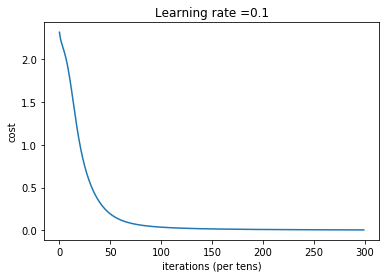

In [333]:
##### CONSTANTS DEFINING THE MODEL ####
n_x = FEATURES
n_h = 300
n_y = 10
layers_dims = (n_x, n_h, n_y)
parameters_w2v = two_layer_model(xtrain_w2v, ytrain_w2v, layers_dims = (n_x, n_h, n_y), 
                             learning_rate = 0.1, num_iterations = 300, print_cost=True)

In [334]:
y_train_pred_w2v = predict(xtrain_w2v, parameters_w2v)
train_accuracy = evaluate(y_train_pred_w2v, ytrain_w2v)

Accuracy: 100.0 %


In [335]:
y_test_pred_w2v = predict(xtest_w2v, parameters_w2v)
test_accuracy = evaluate(y_test_pred_w2v, ytest_w2v)

Accuracy: 78.0 %


In [349]:
layers_dims_L = [FEATURES, 300, 100, 40, 10] #  4-layer model
parameters__w2v_L = L_layer_model(xtrain_w2v, ytrain_w2v, layers_dims_L, 
                           learning_rate = 0.1, num_iterations = 990, print_cost = True)

Cost after iteration 0: 2.302612
Cost after iteration 1: 2.301442
Cost after iteration 2: 2.300294
Cost after iteration 3: 2.299170
Cost after iteration 4: 2.298068
Cost after iteration 5: 2.296989
Cost after iteration 6: 2.295931
Cost after iteration 7: 2.294895
Cost after iteration 8: 2.293880
Cost after iteration 9: 2.292886
Cost after iteration 10: 2.291912
Cost after iteration 11: 2.290958
Cost after iteration 12: 2.290023
Cost after iteration 13: 2.289108
Cost after iteration 14: 2.288212
Cost after iteration 15: 2.287334
Cost after iteration 16: 2.286474
Cost after iteration 17: 2.285632
Cost after iteration 18: 2.284808
Cost after iteration 19: 2.284000
Cost after iteration 20: 2.283210
Cost after iteration 21: 2.282436
Cost after iteration 22: 2.281679
Cost after iteration 23: 2.280937
Cost after iteration 24: 2.280210
Cost after iteration 25: 2.279500
Cost after iteration 26: 2.278804
Cost after iteration 27: 2.278122
Cost after iteration 28: 2.277455
Cost after iteration 29:

Cost after iteration 238: 2.247126
Cost after iteration 239: 2.247115
Cost after iteration 240: 2.247105
Cost after iteration 241: 2.247094
Cost after iteration 242: 2.247084
Cost after iteration 243: 2.247073
Cost after iteration 244: 2.247063
Cost after iteration 245: 2.247053
Cost after iteration 246: 2.247043
Cost after iteration 247: 2.247034
Cost after iteration 248: 2.247024
Cost after iteration 249: 2.247015
Cost after iteration 250: 2.247005
Cost after iteration 251: 2.246996
Cost after iteration 252: 2.246987
Cost after iteration 253: 2.246978
Cost after iteration 254: 2.246969
Cost after iteration 255: 2.246960
Cost after iteration 256: 2.246952
Cost after iteration 257: 2.246943
Cost after iteration 258: 2.246935
Cost after iteration 259: 2.246926
Cost after iteration 260: 2.246918
Cost after iteration 261: 2.246910
Cost after iteration 262: 2.246902
Cost after iteration 263: 2.246894
Cost after iteration 264: 2.246886
Cost after iteration 265: 2.246878
Cost after iteration

Cost after iteration 473: 2.245587
Cost after iteration 474: 2.245574
Cost after iteration 475: 2.245561
Cost after iteration 476: 2.245547
Cost after iteration 477: 2.245533
Cost after iteration 478: 2.245519
Cost after iteration 479: 2.245504
Cost after iteration 480: 2.245489
Cost after iteration 481: 2.245474
Cost after iteration 482: 2.245459
Cost after iteration 483: 2.245443
Cost after iteration 484: 2.245427
Cost after iteration 485: 2.245411
Cost after iteration 486: 2.245394
Cost after iteration 487: 2.245377
Cost after iteration 488: 2.245360
Cost after iteration 489: 2.245342
Cost after iteration 490: 2.245324
Cost after iteration 491: 2.245306
Cost after iteration 492: 2.245287
Cost after iteration 493: 2.245268
Cost after iteration 494: 2.245249
Cost after iteration 495: 2.245229
Cost after iteration 496: 2.245208
Cost after iteration 497: 2.245188
Cost after iteration 498: 2.245166
Cost after iteration 499: 2.245145
Cost after iteration 500: 2.245122
Cost after iteration

Cost after iteration 708: 1.538124
Cost after iteration 709: 1.457353
Cost after iteration 710: 1.427188
Cost after iteration 711: 1.406701
Cost after iteration 712: 1.388441
Cost after iteration 713: 1.371620
Cost after iteration 714: 1.355807
Cost after iteration 715: 1.340801
Cost after iteration 716: 1.326438
Cost after iteration 717: 1.312576
Cost after iteration 718: 1.299207
Cost after iteration 719: 1.286590
Cost after iteration 720: 1.275387
Cost after iteration 721: 1.268681
Cost after iteration 722: 1.276210
Cost after iteration 723: 1.341880
Cost after iteration 724: 1.509635
Cost after iteration 725: 2.099305
Cost after iteration 726: 2.404527
Cost after iteration 727: 1.775206
Cost after iteration 728: 1.509264
Cost after iteration 729: 1.375342
Cost after iteration 730: 1.311879
Cost after iteration 731: 1.282486
Cost after iteration 732: 1.259953
Cost after iteration 733: 1.241612
Cost after iteration 734: 1.226097
Cost after iteration 735: 1.214290
Cost after iteration

Cost after iteration 943: 0.910122
Cost after iteration 944: 1.255757
Cost after iteration 945: 2.323029
Cost after iteration 946: 2.638805
Cost after iteration 947: 2.723158
Cost after iteration 948: 0.979877
Cost after iteration 949: 0.772338
Cost after iteration 950: 0.696985
Cost after iteration 951: 0.648795
Cost after iteration 952: 0.610744
Cost after iteration 953: 0.580061
Cost after iteration 954: 0.554179
Cost after iteration 955: 0.531789
Cost after iteration 956: 0.512254
Cost after iteration 957: 0.494876
Cost after iteration 958: 0.479206
Cost after iteration 959: 0.464957
Cost after iteration 960: 0.451873
Cost after iteration 961: 0.439730
Cost after iteration 962: 0.428385
Cost after iteration 963: 0.417706
Cost after iteration 964: 0.407589
Cost after iteration 965: 0.397956
Cost after iteration 966: 0.388735
Cost after iteration 967: 0.379874
Cost after iteration 968: 0.371307
Cost after iteration 969: 0.362985
Cost after iteration 970: 0.354870
Cost after iteration

In [350]:
y_train_pred_w2v_L = predict(xtrain_w2v, parameters__w2v_L)
train_accuracy = evaluate(y_train_pred_w2v_L, ytrain_w2v)

Accuracy: 94.3 %


In [351]:
y_test_pred_w2v_L = predict(xtest_w2v, parameters__w2v_L)
test_accuracy = evaluate(y_test_pred_w2v_L, ytest_w2v)

Accuracy: 56.49999999999999 %
